# Classification

## Imports

In [414]:
# data handling
import pandas as pd
import numpy as np
import time
# visualization
import matplotlib.pyplot as plt
# machine learning
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
# interpretation
from sklearn.inspection import PartialDependenceDisplay

## Prepare Data

In [415]:
trainDF = pd.read_csv('../app/data/02_train.csv', sep=';')
testDF = pd.read_csv('../app/data/02_test.csv', sep=';')

>Prepare for classification by creating ranges for the totalPrice column

In [416]:
trainDF.describe().totalPrice

count    219943.000000
mean        350.116172
std         232.890170
min           0.100000
25%         205.000000
50%         295.000000
75%         428.000000
max       18130.000000
Name: totalPrice, dtype: float64

In [417]:
testDF.describe().totalPrice

count    94262.000000
mean       349.123993
std        228.231882
min          0.100000
25%        204.625000
50%        294.000000
75%        425.000000
max       5700.000000
Name: totalPrice, dtype: float64

In [418]:
bins = [i for i in range(0, 1010, 10)]
bins.append(float('Inf'))

labels = [i for i in range(0, len(bins)-1, 1)]  # Bin labels must be one fewer than the number of bin edges

idx=0
totalPriceMapping = {}
for i in labels:
    totalPriceMapping[labels[idx]]=f"{bins[idx]} - {bins[idx+1]}"
    idx+=1

print("bins:", bins)
print("labels:", labels)
print("\ntotalPrice mapping:")
print(totalPriceMapping)

bins: [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900, 910, 920, 930, 940, 950, 960, 970, 980, 990, 1000, inf]
labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]

totalPrice mapping:
{0: '0 - 10', 1: '10 - 20', 2: '20 - 30', 3: '30 - 40', 4: '40 - 50'

In [419]:
trainDF['totalPrice'] = pd.cut(trainDF['totalPrice'], bins=bins, labels=labels)  # change totalPrice column to categorial feature with above devined ranges/labels
testDF['totalPrice'] = pd.cut(testDF['totalPrice'], bins=bins, labels=labels)  # change totalPrice column to categorial feature with above devined ranges/labels

In [420]:
trainDF.head(10)

,Lng,Lat,square,livingRoom,drawingRoom,kitchen,bathRoom,floor,buildingType,renovationCondition,...,placeRank,town,districtPopulation,districtArea,tradeYear,tradeMonth,tradeDay,floorType,constructionTimePeriod,totalPrice
0,116.346109,39.756539,73.61,3,1,1,1,6,118742,53150,...,133606,219943,1993591.0,1012.0,2017,8,6,82499,136686,34
1,116.423426,39.964365,58.29,2,1,1,1,5,118742,81641,...,133606,219943,3452460.0,470.8,2013,5,14,82499,136686,31
2,116.513137,39.978272,94.47,2,1,1,1,9,118742,81641,...,133606,219943,3452460.0,470.8,2012,12,29,18058,136686,30
3,116.473376,39.875385,131.63,3,1,1,2,22,58087,53150,...,81988,219943,3452460.0,470.8,2015,4,9,25725,136686,40
4,116.471931,40.008739,103.14,3,2,1,1,18,58087,53150,...,81988,219943,3452460.0,470.8,2017,12,7,82499,136686,66
5,116.387037,39.959170,52.21,1,1,1,1,6,118742,81441,...,133606,219943,708829.0,40.6,2014,10,25,82499,13370,28
6,116.365511,40.036171,85.63,2,1,1,1,13,58087,81641,...,133606,219943,3133469.0,426.0,2012,6,23,48571,136686,21
7,116.378897,40.015057,51.31,1,1,1,1,14,41617,81441,...,81988,219943,3452460.0,470.8,2017,4,20,82499,136686,39
8,116.587907,39.920397,66.03,2,1,1,1,7,118742,53150,...,133606,219943,3452460.0,470.8,2015,2,9,18058,136686,18
9,116.411493,40.000186,106.92,2,2,1,1,15,41617,81441,...,81988,219943,3452460.0,470.8,2017,7,25,44240,136686,76


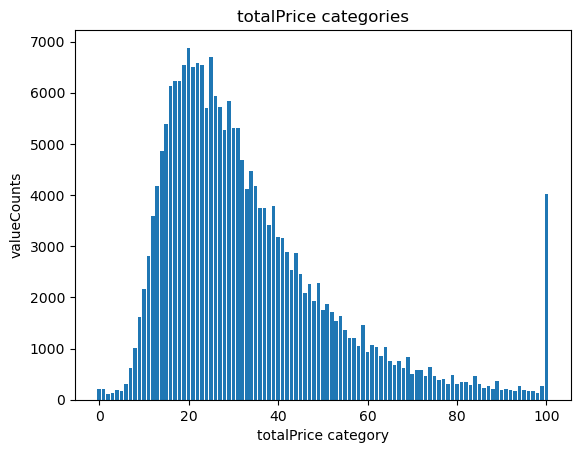

In [421]:
plt.bar(trainDF["totalPrice"].value_counts().index, trainDF["totalPrice"].value_counts().values)
plt.title("totalPrice categories")
plt.xlabel("totalPrice category")
plt.ylabel("valueCounts")
plt.show()

In [422]:
columns = trainDF.columns.to_list()
print(columns)

['Lng', 'Lat', 'square', 'livingRoom', 'drawingRoom', 'kitchen', 'bathRoom', 'floor', 'buildingType', 'renovationCondition', 'buildingStructure', 'ladderRatio', 'elevator', 'fiveYearsProperty', 'subway', 'district', 'communityAverage', 'placeRank', 'town', 'districtPopulation', 'districtArea', 'tradeYear', 'tradeMonth', 'tradeDay', 'floorType', 'constructionTimePeriod', 'totalPrice']


In [423]:
X_train = trainDF.drop(['totalPrice'], axis=1)
y_train = trainDF['totalPrice']
X_test = testDF.drop(['totalPrice'], axis=1)
y_test = testDF['totalPrice']

In [424]:
X = X_train
y = y_train

In [425]:
X

,Lng,Lat,square,livingRoom,drawingRoom,kitchen,bathRoom,floor,buildingType,renovationCondition,...,communityAverage,placeRank,town,districtPopulation,districtArea,tradeYear,tradeMonth,tradeDay,floorType,constructionTimePeriod
0,116.346109,39.756539,73.61,3,1,1,1,6,118742,53150,...,39243.0,133606,219943,1993591.0,1012.0,2017,8,6,82499,136686
1,116.423426,39.964365,58.29,2,1,1,1,5,118742,81641,...,92516.0,133606,219943,3452460.0,470.8,2013,5,14,82499,136686
2,116.513137,39.978272,94.47,2,1,1,1,9,118742,81641,...,73113.0,133606,219943,3452460.0,470.8,2012,12,29,18058,136686
3,116.473376,39.875385,131.63,3,1,1,2,22,58087,53150,...,54612.0,81988,219943,3452460.0,470.8,2015,4,9,25725,136686
4,116.471931,40.008739,103.14,3,2,1,1,18,58087,53150,...,57510.0,81988,219943,3452460.0,470.8,2017,12,7,82499,136686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219938,116.451461,39.949365,57.49,2,1,1,1,6,118742,81641,...,72137.0,81988,219943,3452460.0,470.8,2012,12,15,48571,136686
219939,116.229624,39.915004,44.10,1,1,1,1,6,118742,81641,...,51471.0,81988,219943,3133469.0,426.0,2012,7,7,82499,16497
219940,116.310205,39.987486,138.14,3,2,1,2,16,58087,81641,...,79927.0,81988,219943,3133469.0,426.0,2011,12,5,44240,136686
219941,116.389264,39.886874,96.90,2,1,2,1,16,58087,81441,...,91507.0,4349,219943,1106214.0,46.5,2015,3,21,44240,136686


In [426]:
y

0         34
1         31
2         30
3         40
4         66
          ..
219938    20
219939    10
219940    22
219941    48
219942    28
Name: totalPrice, Length: 219943, dtype: category
Categories (101, int64): [0 < 1 < 2 < 3 ... 97 < 98 < 99 < 100]

## ML

In [ ]:
clf = XGBClassifier(n_jobs=2)
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
accuracy_score(y_test, y_pred)

In [ ]:
# DF with predictions
predDF = X_test
predDF["totalPrice"] = y_test
predDF["prediction"] = y_pred
predDF.head()

In [ ]:
predDF["totalPrice"].describe()

In [ ]:
predDF["prediction"].describe()

## Visualization & Interpretation

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(predDF["prediction"], predDF["totalPrice"], c=predDF["deviation"])
plt.axvline(x=0, color="red")
plt.title("real totalPrice and predicted value (color represents deviation)")
plt.xlabel("prediction")
plt.ylabel("totalPrice")
plt.colorbar()
plt.show()

In [ ]:
columns=['square', 'livingRoom', 'drawingRoom', 'kitchen', 'bathRoom', 'floor', 'buildingType', 'renovationCondition', 'buildingStructure', 'ladderRatio', 'elevator', 'fiveYearsProperty', 'subway', 'district', 'communityAverage', 'placeRank', 'town', 'districtPopulation', 'districtArea', 'tradeYear', 'tradeMonth', 'tradeDay', 'floorType', 'constructionTimePeriod']

plt.figure(figsize=(20,25))
i=0
for groupByFeature in columns:
    i+=1
    plt.subplot(5,5,i)
    plt.plot(predDF.groupby([groupByFeature]).mean()["prediction"])
    plt.title(f"grouped by {groupByFeature}")
    plt.xlabel(groupByFeature)
    plt.ylabel("prediction")
plt.tight_layout()
plt.show()

In [ ]:
n_cols = 4
n_rows = 6
fig, ax = plt.subplots(n_rows, n_cols, figsize=(15,20))
PartialDependenceDisplay.from_estimator(clf, X_train, columns, ax=ax, n_cols=n_cols)
fig.suptitle("PartialDependenceDisplay")
fig.tight_layout(rect=[0, 0, 1, 0.99])
fig.show()